In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import os
import sys

# Get the absolute path to the root directory of the project
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add root to sys.path so "src" becomes importable
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)

from utils.evaluation import calculate_mae, calculate_mda

In [5]:
# Load the Yahoo data
yahoo_data = pd.read_csv('../../dataset/results/AAPL_yahoo_data.csv')

# Preprocess the data
yahoo_data['Date'] = pd.to_datetime(yahoo_data['Date'].str.split(' ').str[0]) # Extract date part and convert
yahoo_data.set_index('Date', inplace=True)
data = yahoo_data['Adj Close'].dropna() # Use Adjusted Close price and drop any potential NaNs

# Explicitly set frequency
data = data.asfreq('B')  # Business day frequency

# Split data into training and testing sets (e.g., last 30 days for testing)
train_data = data[:-10]
test_data = data[-10:]

# Implement ARIMA model
# For baseline, let's use a simple order (5,1,0). Parameter tuning is not the focus here for baseline.
order = (5, 1, 1) # (p, d, q)
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test_data))

predictions_series = pd.Series(predictions, index=test_data.index)

# --- Evaluation Metrics as per proposal ---

# def calculate_mda(actual, predicted):
#     """
#     Calculates Mean Directional Accuracy (MDA).
#     """
#     actual_returns = actual.pct_change().dropna()
#     predicted_returns = predicted.pct_change().dropna()

#     # Align indices in case of any mismatch due to pct_change
#     common_index = actual_returns.index.intersection(predicted_returns.index)
#     actual_returns = actual_returns.loc[common_index]
#     predicted_returns = predicted_returns.loc[common_index]

#     correct_direction = np.sign(actual_returns) == np.sign(predicted_returns)
#     mda = np.mean(correct_direction)
#     return mda

def calculate_sharpe_ratio(predicted_returns, risk_free_rate=0.0, trading_days=252):
    """
    Calculates annualized Sharpe Ratio.
    Assuming predicted_returns are daily returns.
    """
    excess_returns = predicted_returns - (risk_free_rate / trading_days)
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    annualized_sharpe_ratio = sharpe_ratio * np.sqrt(trading_days)
    return annualized_sharpe_ratio

def calculate_pearson_correlation(actual, predicted):
    """
    Calculates Pearson Correlation between actual and predicted returns.
    """
    actual_returns = actual.pct_change().dropna()
    predicted_returns = predicted.pct_change().dropna()

    # Align indices
    common_index = actual_returns.index.intersection(predicted_returns.index)
    actual_returns = actual_returns.loc[common_index]
    predicted_returns = predicted_returns.loc[common_index]

    correlation = np.corrcoef(actual_returns, predicted_returns)[0, 1]
    return correlation


# Calculate evaluation metrics
mda = calculate_mda(test_data, predictions_series)

# Calculate predicted returns for Sharpe Ratio
predicted_returns_for_sharpe = predictions_series.pct_change().dropna() # Returns based on predicted prices
sharpe_ratio = calculate_sharpe_ratio(predicted_returns_for_sharpe)

# print(test_data)
# print(predictions_series)

pearson_correlation = calculate_pearson_correlation(test_data, predictions_series)


# --- Additional common metrics (MAE, RMSE) for completeness ---
mae = mean_absolute_error(test_data, predictions_series)
rmse = sqrt(mean_squared_error(test_data, predictions_series))


# Print results
print("ARIMA Baseline Model Evaluation Metrics:")
print(f"  Mean Directional Accuracy (MDA): {mda:.4f}")
print(f"  Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"  Pearson Correlation (of returns): {pearson_correlation:.4f}")
print("\nAdditional Metrics (for reference):")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")

ARIMA Baseline Model Evaluation Metrics:
  Mean Directional Accuracy (MDA): 1.0000
  Annualized Sharpe Ratio: -0.5260
  Pearson Correlation (of returns): 0.2135

Additional Metrics (for reference):
  Mean Absolute Error (MAE): 5.7484
  Root Mean Squared Error (RMSE): 7.0199


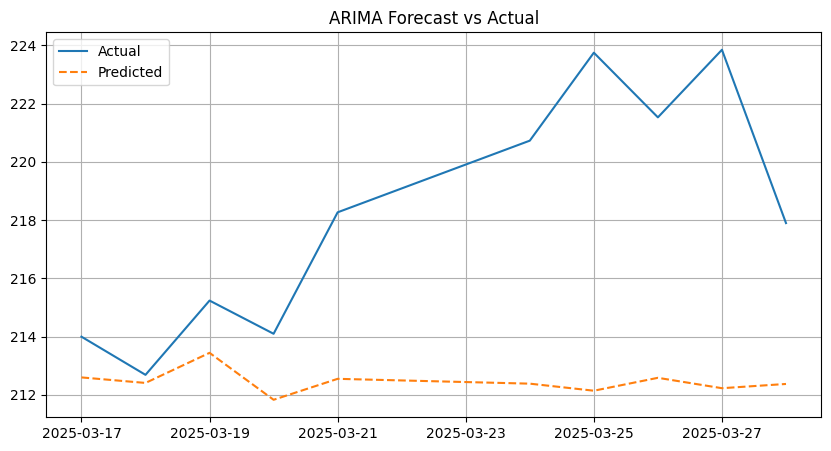

In [6]:
plt.figure(figsize=(10,5))
plt.plot(test_data, label='Actual')
plt.plot(predictions_series, label='Predicted', linestyle='--')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()